<p style="text-align:center;">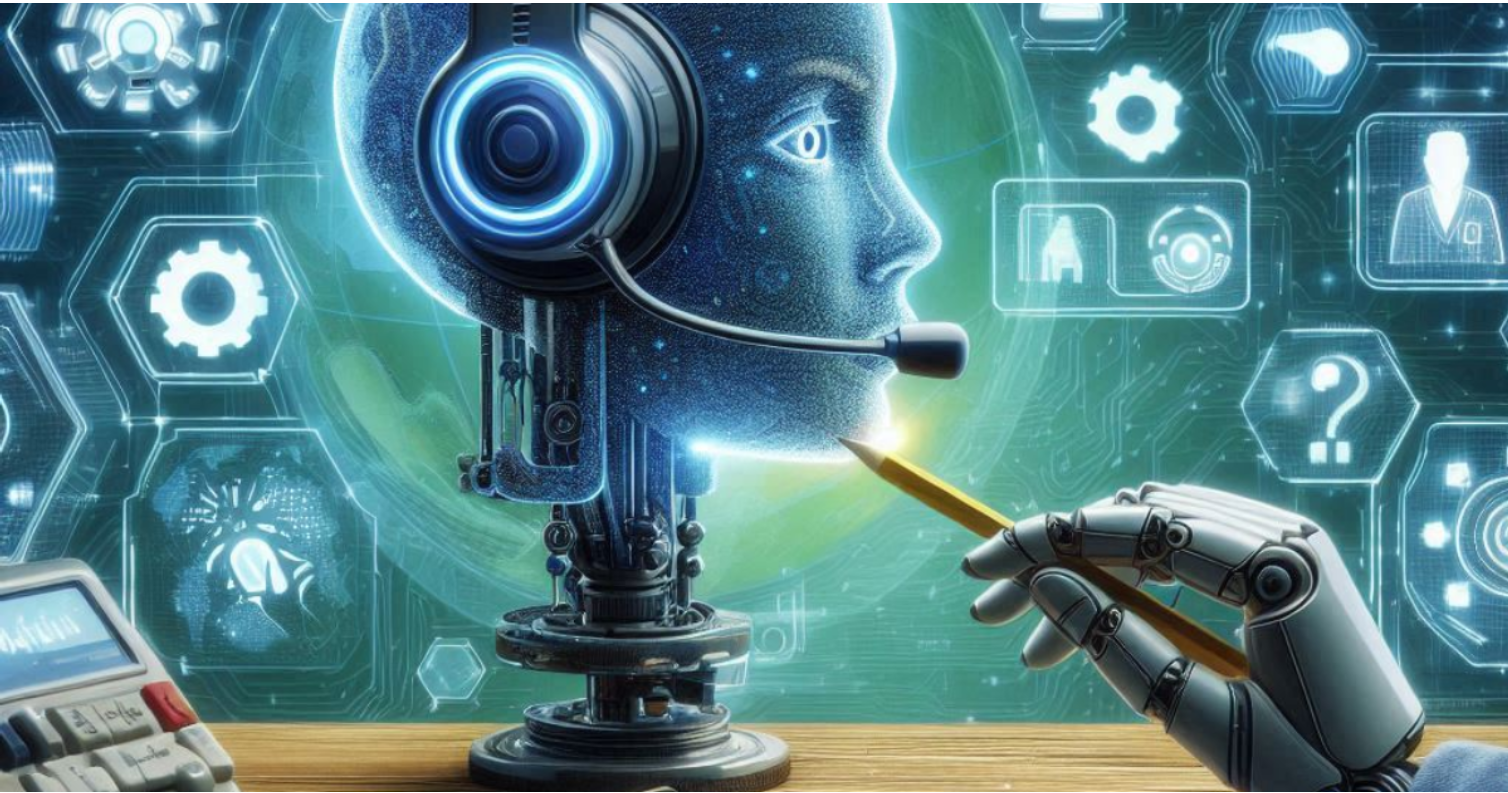
</p>

This is an agent capable of function calling in order to answer user's questions about a document. It's powered by Mixtral 8x22B MoE model.

In [3]:
import json
import os
import re
import requests
from transformers import AutoTokenizer

from llama_index.core import Settings, SimpleDirectoryReader, VectorStoreIndex, SummaryIndex
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core.tools import FunctionTool, QueryEngineTool, BaseTool
from llama_index.core.vector_stores import MetadataFilters, FilterCondition
from llama_index.llms.openai_like import OpenAILike
from llama_index.embeddings.huggingface import HuggingFaceEmbedding


import nest_asyncio
nest_asyncio.apply()

from dotenv import load_dotenv
load_dotenv();

## Configure default LLM and embedding model for LlamaIndex

In [4]:
def get_model_name():
    BASE_URL = os.environ['BASE_URL']
    headers = {
        'accept': 'application/json',
        'x-api-key': os.environ['API_KEY']
    }
    res = requests.get(os.path.join(BASE_URL, 'model'), headers=headers).json()
    if 'id' not in res:
        raise Exception('Model not loaded.')
    return res['id']

In [5]:
model_name = get_model_name()
print(model_name)

llm = OpenAILike(
    model=model_name,
    api_base=os.environ['BASE_URL'],
    api_key=os.environ['API_KEY']
)
tokenizer = AutoTokenizer.from_pretrained('mistralai/Mixtral-8x22B-Instruct-v0.1')

embed_model = HuggingFaceEmbedding(
    'BAAI/bge-base-en-v1.5',
    cache_folder=os.environ['HF_CACHE_DIR'])

Settings.llm = llm
Settings.embed_model = embed_model

Mixtral-8x22B-Instruct-v0.1-exl2-4.0bpw


/home/jovyan/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## Define a function calling custom agent

In [6]:
def format_prompt(messages, tokenizer, use_tool=False, tools=None):
    if use_tool:
        if tools is None or len(tools)==0:
            raise Exception('A list of tools is required for function calling.')
        prompt = tokenizer.apply_chat_template(
            messages,
            chat_template='tool_use',
            tools=json.dumps(tools),
            tokenize=False,
            add_generation_prompt=True)
    else:
        prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    return prompt

In [7]:
class MixtralFunctionCallingAgent:
    def __init__(
        self,
        llm: OpenAILike,
        tokenizer: AutoTokenizer,
        tool_param_desc_pairs: list[tuple[BaseTool, dict]],
        initial_memory: list[dict] = []
    ) -> None:
        self._llm = llm
        self._tokenizer = tokenizer
        self._initial_memory = initial_memory.copy()
        self._memory = initial_memory.copy()
        self._tool_specs = []
        self._tools = {}
        for tool, param_desc in tool_param_desc_pairs:
            tool_spec = self._get_fn_tool_spec(tool, param_desc)
            self._tool_specs.append(tool_spec)
            self._tools[tool.metadata.name] = tool

    def reset(self) -> None:
        self._memory = self._initial_memory.copy()

    def chat(self, message: str) -> str:
        self._memory.append({'role': 'user', 'content': message})
        while True:    
            response, prompt = self._run_step()

            print('----------DEBUG----------')
            print(response)
            print('-------------------------\n')

            toolcall = self._get_first_toolcall(response)
            if toolcall:
                self._single_tool_call(toolcall)
            else:
                self._memory.append({'role': 'assistant', 'content': response})
                return response, prompt

    def _run_step(self):
        prompt = format_prompt(self._memory, self._tokenizer, True, self._tool_specs)
        response = self._llm.complete(prompt, formatted=True).text.strip()
        return response, prompt

    def _get_first_toolcall(self, response: str) -> dict|None:
        m = re.findall('(\{\s*"name":.*?\}\})+', response)
        if len(m) > 0:
            try:
                toolcalls = json.loads(m[0])
                return toolcalls
            except:
                return None
        else:
            return None

    def _single_tool_call(self, tool_call: dict) -> str:
        self._memory.append(
            {'role': 'tool_calls', 'content': json.dumps([tool_call], ensure_ascii=False)}
        )
        
        tool_results = self._call_tool(tool_call)
        self._memory.append(
            {'role': 'tool_results', 'content': json.dumps({'content': tool_results}, ensure_ascii=False)}
        )
    
    def _call_tool(self, tool_call: dict) -> str:
        tool = self._tools[tool_call['name']]
        results = tool(**tool_call['arguments'])
        return results.content.strip()
            
    def _get_fn_tool_spec(self, fn_tool, tool_param_descriptions):
        fn_tool_spec = fn_tool.metadata.to_openai_tool()
        for k, v in fn_tool_spec['function']['parameters']['properties'].items():
            v.pop('title', None)
            v['description'] = tool_param_descriptions[k]
        return fn_tool_spec

## Create indexes for documents

In [8]:
documents = SimpleDirectoryReader(
    input_files=["MoRA: High-Rank Updating for Parameter-Efficient Fine-Tuning.pdf"]
).load_data()

splitter = SentenceSplitter(chunk_size=1024)
nodes = splitter.get_nodes_from_documents(documents)

vector_index = VectorStoreIndex(nodes)
summary_index = SummaryIndex(nodes)

In [9]:
def vector_query(query: str, page_numbers: list[str] | None = None) -> str:
    """Useful for answering questions about the MoRA paper.
Always leave page_numbers as None unless you want to search for a specific page.

Args:
    query (str): the string query to be embedded.
    page_numbers (List[str] | None): Filter by set of pages. Leave as NONE if we want to perform a vector search over all pages. Otherwise, filter by the set of specified pages."""

    page_numbers = page_numbers or []
    metadata_dicts = [
        {"key": "page_label", "value": p} for p in page_numbers
    ]

    query_engine = vector_index.as_query_engine(
        similarity_top_k=2,
        filters=MetadataFilters.from_dicts(
            metadata_dicts,
            condition=FilterCondition.OR
        )
    )
    response = query_engine.query(query)
    return response

vector_tool_param_descriptions = {
    'query': 'the string query to be embedded.',
    'page_numbers': 'Filter by set of pages. Leave as NONE if we want to perform a vector search over all pages. Otherwise, filter by the set of specified pages.'
}
vector_tool = FunctionTool.from_defaults(name='vector_tool_mora', fn=vector_query)

def summary_query(query: str) -> str:
    """Use ONLY IF you want to get a holistic summary of MoRA. Avoid it if you have specific questions over MoRA.

Args:
    query (str): the string query to be embedded."""
    summary_query_engine = summary_index.as_query_engine(
        response_mode='tree_summarize',
        use_async=True
    )
    response = summary_query_engine.query(query)
    return response.response

summary_tool_param_descriptions = {'query': 'the string query to be embedded.'}
summary_tool = FunctionTool.from_defaults(name='summary_tool_mora', fn=summary_query)

tool_param_desc_pairs = [
    (vector_tool, vector_tool_param_descriptions),
    (summary_tool, summary_tool_param_descriptions),
]

## Query the document

In [10]:
agent = MixtralFunctionCallingAgent(
    llm=llm,
    tokenizer=tokenizer,
    tool_param_desc_pairs=tool_param_desc_pairs,
)

In [11]:
response, _ = agent.chat("What are the main contributions of the MoRA paper?")
print(response)

----------DEBUG----------
[{"name": "summary_tool_mora", "arguments": {"query": "What are the main contributions of the MoRA paper?"}}]
-------------------------

----------DEBUG----------
The main contributions of the MoRA paper are:

1. Introducing MoRA, a method that utilizes non-parameterized operators for high-rank updating to overcome the limitations of low-rank updating through LoRA.
2. Exploring various methods to implement decompresion and compression functions within the MoRA framework.
3. Performance comparisons indicating that MoRA matches LoRA in instruction tuning and mathematical reasoning, and exhibits superior performance in continual pretraining and memory tasks.
4. Conducting pretraining experiments to further demonstrate the effectiveness of high-rank updating and showing superior results compared to ReLoRA.
5. Proposing a novel method for parameter-efficient fine-tuning of large-scale pre-trained models, which is based on high-rank updating.
6. Introducing the conc

### Reset the agent's memory for a new chat session.

In [21]:
agent.reset()

In [22]:
response, _ = agent.chat("What are the main results of MoRA described on page 7?")
print(response)

----------DEBUG----------
[{"name": "vector_tool_mora", "arguments": {"query": "What are the main results of MoRA described on page 7?", "page_numbers": ["7"]}}]
-------------------------

----------DEBUG----------
According to the results described on page 7 of MoRA, the model shows on par performances with LoRA on instruction tuning and mathematical reasoning. MoRA benefits from high-rank updating to memorize new knowledge and outperforms LoRA on both biomedical and financial domains for continual pre-training. LoRA variants exhibit similar performances on these fine-tuning tasks as compared to LoRA. Although AsyLoRA achieves the best performance in instruction tuning, it demonstrates poor performance in mathematical reasoning. For ReLoRA, merging low-rank matrices during training can harm performance, particularly at the high rank like 256. Different tasks show different requirements for fine-tuning capabilities. For instruction tuning, rank 8 is enough to achieve performance simila

In [24]:
response, _ = agent.chat("How do MoRA compared with LoRA?")
print(response)

----------DEBUG----------
[{"name": "vector_tool_mora", "arguments": {"query": "How do MoRA compared with LoRA?"}}]
-------------------------

----------DEBUG----------
According to the results, MoRA shows on par performances with LoRA on instruction tuning and mathematical reasoning. MoRA benefits from high-rank updating to memorize new knowledge and outperforms LoRA on both biomedical and financial domains for continual pre-training. However, LoRA variants exhibit similar performances on these fine-tuning tasks as compared to LoRA. Although AsyLoRA achieves the best performance in instruction tuning, it demonstrates poor performance in mathematical reasoning. For ReLoRA, merging low-rank matrices during training can harm performance, particularly at the high rank like 256.
-------------------------

According to the results, MoRA shows on par performances with LoRA on instruction tuning and mathematical reasoning. MoRA benefits from high-rank updating to memorize new knowledge and ou

In [25]:
response, _ = agent.chat("What are the main points of High-rank Updating on page 8?")
print(response)

----------DEBUG----------
[{"name": "vector_tool_mora", "arguments": {"query": "What are the main points of High-rank Updating on page 8?", "page_numbers": ["8"]}}]
-------------------------

----------DEBUG----------
According to the main points of High-rank Updating on page 8, the impact of high-rank updating on the rank of ∆W was demonstrated by analyzing the spectrum of singular values for the learned ∆W on a 250M pretraining model. MoRA and ReMoRA exhibit a substantially higher number of significant singular values compared to LoRA and ReLoRA, highlighting the effectiveness of these methods in increasing the rank of ∆W. The quantity of singular values shown in Figure 5 can be correlated with the perplexity metrics listed in Table 3. MoRA, without the merge-and-reint strategy in ReLoRA and ReMoRA, can achieve a lower perplexity than ReLoRA along with a higher significant singular values.
-------------------------

According to the main points of High-rank Updating on page 8, the im

### Take a look at chat history

In [27]:
agent._memory

[{'role': 'user',
  'content': 'What are the main results of MoRA described on page 7?'},
 {'role': 'tool_calls',
  'content': '[{"name": "vector_tool_mora", "arguments": {"query": "What are the main results of MoRA described on page 7?", "page_numbers": ["7"]}}]'},
 {'role': 'tool_results',
  'content': '{"content": "MoRA shows on par performances with LoRA on instruction tuning and mathematical reasoning. Benefit from high-rank updating to memorize new knowledge, MoRA outperforms LoRA on both biomedical and financial domains for continual pre-training. LoRA variants exhibit similar performances on these fine-tuning tasks as compared to LoRA. Although AsyLoRA achieves the best performance in instruction tuning, it demonstrates poor performance in mathematical reasoning. For ReLoRA, merging low-rank matrices during training can harm performance, particularly at the high rank like 256. Different tasks show different requirements for fine-tuning capabilities. For instruction tuning, rank

### Ask the model to summarize the conversation

In [28]:
response, _ = agent.chat("Summarize our chat in bullet points")
print(response)

----------DEBUG----------
1. MoRA is a model that shows on par performances with LoRA on instruction tuning and mathematical reasoning.
2. MoRA benefits from high-rank updating to memorize new knowledge and outperforms LoRA on both biomedical and financial domains for continual pre-training.
3. LoRA variants exhibit similar performances on these fine-tuning tasks as compared to LoRA.
4. Although AsyLoRA achieves the best performance in instruction tuning, it demonstrates poor performance in mathematical reasoning.
5. For ReLoRA, merging low-rank matrices during training can harm performance, particularly at the high rank like 256.
6. Different tasks show different requirements for fine-tuning capabilities. For instruction tuning, rank 8 is enough to achieve performance similar to FFT. For mathematical reasoning, rank 8 is unable to match FFT performance. However, increasing the rank from 8 to 256 can eliminate the performance gap.
7. For continual pretraining, LoRA with rank 256 still 